<a href="https://colab.research.google.com/github/Freddy-94/PSO_Implementation/blob/main/Swarm_intelligence_PSO_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Alfredo Bernal Luna
### Practice No. 4. Swarm intelligence - PSO algorithm.

# Modules to be used in this program:

In [ ]:
import numpy as np                      # for Acleys plot
from numpy import sqrt, cos, e, pi, exp # for Ackley's function plot
import random                           # for randoms
import matplotlib.pyplot as plt         # to plot

# Definition of cost function:

1. Ackley's function.

   Let $f : {[-32.768, 32.768]} ^n \to \mathbb{R}$ given by:

  \begin{align}
          f(\mathbf{x}) = -20\mathrm{e}^{-0.2\sqrt{1/n\sum_{i=1}^n x_{i}^{2}}} - \mathrm{e}^{1/n\sum_{i=1}^n \cos {2\pi x_{i}}} + 20 + \mathrm{e}
  \end{align}

In [ ]:
def ackley(n, x):
    gen_cos_avg = 0
    root_mean_square = 0
    for i in range(0, n):
        gen_cos_avg += cos(2*pi*x[i])
        root_mean_square += x[i]**2
    root_mean_square = sqrt((1/n)*(root_mean_square))
    gen_cos_avg /= n
    ackley = -20*exp((-0.2)*(root_mean_square)) - exp(gen_cos_avg) +  20 + e
    return ackley

# Test of the cost functions (dimension = 10):

In [ ]:
ackley(10, [31.0261, -31.6548, -21.265, 20.264, 10.00156, -20.0165, -30.1235, 20.0326, 10.698, 10.145])

20.94917772543559

# Graph of Ackley's function in 3D:

In [ ]:
def plot_cost_function_3d(vars_domain, num_points_to_plot, cost_fun):
    """
    Function to plot the graphs of the cost functions, in 3 dimensions. This function might be
    useful to gain more intuition on the problem at hand
    """
    x1 = np.linspace(vars_domain[0], vars_domain[1], num_points_to_plot)
    x2 = x1
    coord_array_x1, coord_array_x2 = np.meshgrid(x1, x2)
    cost = cost_fun(2, [coord_array_x1, coord_array_x2])
    fig = plt.figure()
    ax = plt.axes(projection = '3d')
    ax.plot_surface(coord_array_x1, coord_array_x2, cost, rstride = 1, cstride = 1,
                    cmap = 'viridis', edgecolor = 'none')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()

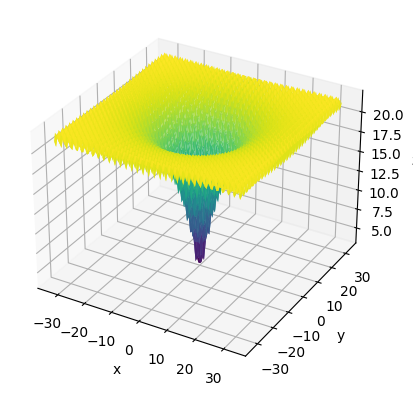

In [ ]:
plot_cost_function_3d([-32.768, 32.768], 100, ackley)

# Class particle to model a particle object

In [ ]:
class Particle:
    def __init__(self):
        """
        Atributes needed to model a particle
        """
        self.lower_bounds = []
        self.upper_bounds = []
        self.position = []
        self.velocity = []
        self.historic_fitnesses = []

    def store_fitnesses(self, particle_trace):
        """
        Mutator method for setting the fitness of the particle
        """
        self.historic_fitnesses.append(particle_trace)

    def find_pBest(self, max_min):
        """
        Method for returning the pBest of the particle
        """
        if max_min == "max":
            pBest = max(self.historic_fitnesses, key = lambda x: x[1])
        else:
            pBest = min(self.historic_fitnesses, key = lambda x: x[1])
        return pBest

    def set_lower_bounds(self, dom_low_bounds):
        """
        Mutator method for setting the low boundaries where the cost function is
        defined; i.e., if the domain of the cost function is:
        [a1, b1] x [a2, b2] x ... x [a_n, b_n]
        then, the dow_low_bounds = [a1, a2, ..., a_n]
        """
        self.lower_bounds = dom_low_bounds

    def set_upper_bounds(self, dom_upper_bounds):
        """
        Mutator method for setting the upper boundaries where the cost function is
        defined; i.e., if the domain of the cost function is:
        [a1, b1] x [a2, b2] x ... x [a_n, b_n]
        then, the dow_upper_bounds = [b1, b2, ..., b_n]
        """
        self.upper_bounds = dom_upper_bounds

    def set_random_initial_position(self):
        """
        Mutator method for setting the initial random position that the particle
        will have
        """
        for i in range(len(self.lower_bounds)):
            self.position.append(round(random.uniform(self.lower_bounds[i], self.upper_bounds[i]), 5))

    def set_random_initial_velocity(self):
        """
        Mutator method for setting the initial random velocity that the particle
        will have
        """
        for i in range(len(self.lower_bounds)):
            self.velocity.append(round(random.uniform(self.lower_bounds[i], self.upper_bounds[i]), 5))

    def update_velocity(self, w, c1, pBest, c2, gBest):
        """
        Mutator method for updating the current velocity of the particle
        """
        for i in range(len(self.velocity)):
            r1 = random.uniform(0, 1)
            r2 = random.uniform(0, 1)
            self.velocity[i] = (w * self.velocity[i]) + (c1 * r1) * (pBest[i] - self.position[i]) + (c2 * r2) * (gBest[i] - self.position[i])

    def update_position(self):
        """
        Mutator method for updating the current position of the particle
        """
        for i in range(len(self.position)):
            self.position[i] += self.velocity[i]

    def validate_bounds(self):
        """
        For not jumping outside of the domain of the cost function.
        We're considering functions with domain of the form:
        [a1, b1] x [a2, b2] x ... x [a_n, b_n]
        """
        for i in range(len(self.position)):
            if self.position[i] < self.lower_bounds[i] or self.position[i] > self.upper_bounds[i]:
                self.position[i] = random.uniform(self.lower_bounds[i], self.upper_bounds[i])

# Class list to model the swarm particles

In [ ]:
class Swarm:
    def __init__(self):
        self.particles = []

    def append(self, particle):
        self.particles += [particle]

    def __len__(self):
        return len(self.particles)

    def removeLast(self):
        return self.particles.pop()

    """
    if we want to iterate over this sequence, we define the special method
    called __iter__(self).
    Without this we'll get "builtins.TypeError:
    'Swarm' object is not iterable", if we try to write for cmd in seq,
    where seq is one of these sequences.
    The yield below will yield an element of the sequence and will suspend
    the execution of the for loop in the method below until the next element is
    needed. The ability to yield each element of the sequence as needed is called
    "lazy" evaluation and is very powerful. It means that we only need to provide
    access to as many of elements of the sequence as are necessary and no more.
    """
    def __iter__(self):
        for p in self.particles:
            yield p

# Class parameters to model an abstract parameter object

In [ ]:
class Parameters:
    def __init__(self, weight, cognitive, social, swarm, max_iters):
        self.inercia_weight = weight
        self.cognitive_factor = cognitive
        self.social_factor = social
        self.swarm_size = swarm
        self.max_iterations = max_iters

    def get_weight(self):
        return self.inercia_weight

    def get_cognision(self):
        return self.cognitive_factor

    def get_social(self):
        return self.social_factor

    def get_swarm_size(self):
        return self.swarm_size

    def get_max_iterations(self):
        return self.max_iterations


# Initialize random swarm

In [ ]:
def initialize_swarm(size, lower_bounds, upper_bounds):
    swarm = Swarm()
    for i in range(size):
        p = Particle()
        p.set_lower_bounds(lower_bounds)
        p.set_upper_bounds(upper_bounds)
        p.set_random_initial_position()
        p.set_random_initial_velocity()
        swarm.append(p)
    return swarm

# Unit test for the correct initialization of a random swarm in 3-D

In [ ]:
init_swarm = initialize_swarm(5, [-32.768, -32.768, -32.768], [32.768, 32.768, 32.768])
print(f"Particles position vectors\t\t\tParticles velocity vectors")
print("=======================================================================================")
for particle in init_swarm:
    print(f"{particle.position}\t\t\t{particle.velocity}")

Particles position vectors			Particles velocity vectors
[28.60062, 22.537, -13.0056]			[-28.84652, -1.62201, 21.32206]
[-25.04398, 15.275, 5.34696]			[5.79605, 10.44875, -28.85178]
[-18.34673, 16.5233, 22.76369]			[-32.58757, -16.21177, -22.4172]
[12.71813, 16.68186, -26.94949]			[-24.87658, 6.87725, 13.77344]
[-1.81029, 15.97211, 23.56252]			[-26.40344, 25.78914, 23.1132]


# Swarm evaluation

In [ ]:
def swarm_eval(swarm, cost_fun):
    fitness_list = []
    for particle in swarm:
        dim = len(particle.lower_bounds)
        particle_fitness = round(cost_fun(dim, particle.position), 5)
        particle_trace = [particle.position, particle_fitness]
        particle.store_fitnesses(particle_trace)
        fitness_list.append(particle_trace)
    return fitness_list

# Unit test for the correct evaluation of swarm values, in 3-D

In [ ]:
swarm_fitness = swarm_eval(init_swarm, ackley)
print(swarm_fitness)

[[[28.60062, 22.537, -13.0056], 21.71719], [[-25.04398, 15.275, 5.34696], 20.99806], [[-18.34673, 16.5233, 22.76369], 21.69264], [[12.71813, 16.68186, -26.94949], 21.21215], [[-1.81029, 15.97211, 23.56252], 20.8215]]


# Obtain the gBest of the swarm

In [ ]:
def find_gBest(swarm_fitness, max_min):
    if max_min == "max":
        gBest = max(swarm_fitness, key = lambda x: x[1])
    else:
        gBest = min(swarm_fitness, key = lambda x: x[1])
    return gBest

# Unit test for the correct search of the gBest of the swarm. Notice that since we're considering the Ackley's function, we want to minimize!

In [ ]:
gBest = find_gBest(swarm_fitness, "min")
print(gBest)

[[-1.81029, 15.97211, 23.56252], 20.8215]


# Integration of the PSO algorithm

In [ ]:
def pso_algo(w, c1, c2, size, lower_bounds, upper_bounds, cost_fun, max_min, max_iters):
    swarm = initialize_swarm(size, lower_bounds, upper_bounds)
    swar_fitnesses = swarm_eval(swarm, cost_fun)
    gBests_found = []
    gBest = find_gBest(swar_fitnesses, max_min)
    gBests_found.append(gBest[1])
    iters = 0
    while iters < max_iters:
        for particle in swarm:
            particle_pBest = particle.find_pBest(max_min)[0]
            particle.update_velocity(w, c1, particle_pBest, c2, gBest[0])
            particle.update_position()
            particle.validate_bounds()
        swar_fitnesses = swarm_eval(swarm, cost_fun)
        newgBest = find_gBest(swar_fitnesses, max_min)
        if max_min == "max":
            if newgBest[1] > gBest[1]:
                gBest = newgBest
        else:
            if gBest[1] > newgBest[1]:
                gBest = newgBest
        gBests_found.append(gBest[1])
        iters += 1
    return gBest, np.mean(gBests_found), np.std(gBests_found)

In [ ]:
def initialize_experiments(parameter, num_experiments, dim, lower_bounds, upper_bounds, max_min):
    best_sols_experiments = []
    medians_experiments = []
    std_devs_experiments = []
    for i in range(num_experiments):
        best_sol, median, standard_deviation = pso_algo(parameter.get_weight(), parameter.get_cognision(), parameter.get_social(), parameter.get_swarm_size(), lower_bounds, upper_bounds, ackley, max_min, parameter.get_max_iterations())
        best_sols_experiments.append(best_sol)
        medians_experiments.append(median)
        std_devs_experiments.append(standard_deviation)
    return best_sols_experiments, medians_experiments, std_devs_experiments

# Main function to call the PSO algorithm

In [ ]:
def main():
    experiments = 20
    dim = 10
    lower_bounds = dim * [-32.768]
    upper_bounds = dim * [32.768]
    max_min = "min"
    c1  = Parameters(0.5, 0.0, 0.5, 50, 1000)
    c2  = Parameters(0.5, 0.0, 2.0, 50, 1000)
    c3  = Parameters(0.5, 0.5, 0.0, 50, 1000)
    c4  = Parameters(0.5, 2.0, 0.0, 50, 1000)
    c5  = Parameters(0.5, 0.5, 2.0, 50, 1000)
    c6  = Parameters(0.5, 2.0, 0.5, 50, 1000)
    c7  = Parameters(0.5, 0.0, 0.5, 50, 1000)
    c8  = Parameters(0.5, 0.0, 2.0, 50, 1000)
    c9  = Parameters(0.5, 0.5, 0.0, 50, 1000)
    c10 = Parameters(0.5, 2.0, 0.0, 50, 1000)
    c11 = Parameters(0.5, 0.5, 2.0, 50, 1000)
    c12 = Parameters(0.5, 2.0, 0.5, 50, 1000)

    best_sols_exp_c1, medians_exps_c1, std_devs_exps_c1 = initialize_experiments(c1, 20, dim, lower_bounds, upper_bounds, max_min)
    best_sols_exp_c2, medians_exps_c2, std_devs_exps_c2 = initialize_experiments(c2, 20, dim, lower_bounds, upper_bounds, max_min)
    best_sols_exp_c3, medians_exps_c3, std_devs_exps_c3 = initialize_experiments(c3, 20, dim, lower_bounds, upper_bounds, max_min)
    best_sols_exp_c4, medians_exps_c4, std_devs_exps_c4 = initialize_experiments(c4, 20, dim, lower_bounds, upper_bounds, max_min)
    best_sols_exp_c5, medians_exps_c5, std_devs_exps_c5 = initialize_experiments(c5, 20, dim, lower_bounds, upper_bounds, max_min)
    best_sols_exp_c6, medians_exps_c6, std_devs_exps_c6 = initialize_experiments(c6, 20, dim, lower_bounds, upper_bounds, max_min)
    best_sols_exp_c7, medians_exps_c7, std_devs_exps_c7 = initialize_experiments(c7, 20, dim, lower_bounds, upper_bounds, max_min)
    best_sols_exp_c8, medians_exps_c8, std_devs_exps_c8 = initialize_experiments(c8, 20, dim, lower_bounds, upper_bounds, max_min)
    best_sols_exp_c9, medians_exps_c9, std_devs_exps_c9 = initialize_experiments(c9, 20, dim, lower_bounds, upper_bounds, max_min)
    best_sols_exp_c10, medians_exps_c10, std_devs_exps_c10 = initialize_experiments(c10, 20, dim, lower_bounds, upper_bounds, max_min)
    best_sols_exp_c11, medians_exps_c11, std_devs_exps_c11 = initialize_experiments(c11, 20, dim, lower_bounds, upper_bounds, max_min)
    best_sols_exp_c12, medians_exps_c12, std_devs_exps_c12 = initialize_experiments(c12, 20, dim, lower_bounds, upper_bounds, max_min)

    print("Best solutions")
    print("==================================================================================")
    print(f"Config 1: {best_sols_exp_c1}")
    print(f"Config 2: {best_sols_exp_c2}")
    print(f"Config 3: {best_sols_exp_c3}")
    print(f"Config 4: {best_sols_exp_c4}")
    print(f"Config 5: {best_sols_exp_c5}")
    print(f"Config 6: {best_sols_exp_c6}")
    print(f"Config 7: {best_sols_exp_c7}")
    print(f"Config 8: {best_sols_exp_c8}")
    print(f"Config 9: {best_sols_exp_c9}")
    print(f"Config 10: {best_sols_exp_c10}")
    print(f"Config 11: {best_sols_exp_c11}")
    print(f"Config 12: {best_sols_exp_c12}")
    print("Means")
    print("==================================================================================")
    print(f"Config 1: {medians_exps_c1}")
    print(f"Config 2: {medians_exps_c2}")
    print(f"Config 3: {medians_exps_c3}")
    print(f"Config 4: {medians_exps_c4}")
    print(f"Config 5: {medians_exps_c5}")
    print(f"Config 6: {medians_exps_c6}")
    print(f"Config 7: {medians_exps_c7}")
    print(f"Config 8: {medians_exps_c8}")
    print(f"Config 9: {medians_exps_c9}")
    print(f"Config 10: {medians_exps_c10}")
    print(f"Config 11: {medians_exps_c11}")
    print(f"Config 12: {medians_exps_c12}")
    print("Std deviations")
    print("==================================================================================")
    print(f"Config 1: {std_devs_exps_c1}")
    print(f"Config 2: {std_devs_exps_c2}")
    print(f"Config 3: {std_devs_exps_c3}")
    print(f"Config 4: {std_devs_exps_c4}")
    print(f"Config 5: {std_devs_exps_c5}")
    print(f"Config 6: {std_devs_exps_c6}")
    print(f"Config 7: {std_devs_exps_c7}")
    print(f"Config 8: {std_devs_exps_c8}")
    print(f"Config 9: {std_devs_exps_c9}")
    print(f"Config 10: {std_devs_exps_c10}")
    print(f"Config 11: {std_devs_exps_c11}")
    print(f"Config 12: {std_devs_exps_c12}")

if __name__ == '__main__':
    main()

Best solutions
Config 1: [[[-0.03765722962334417, 1.9093371401861727, 1.845672808071449, 1.8950709977799767, 0.9887024951642309, -0.01686133954539809, 0.8907964600081735, -0.028127887003673132, 1.9273476087769206, 0.937654724352037], 4.91339], [[-4.930971779473244, -0.015086846528271948, -0.005116625354411267, -1.0671152672984958, -3.975241640657445, -1.9572380123361377, 0.0036766009875715874, -2.964228526462535, -1.0747079037782648, -3.859941513646777], 8.40593], [[0.9899130561908198, 0.9940836984871553, -1.005544900568525, 2.886370892079453, 0.9721739548264213, 0.9782852531176873, 0.01599660294207652, -4.894996019992645, 2.9355835542848197, -0.009168899952899013], 7.11396], [[0.9935678491656301, -2.000931024645745, 0.06886255540979278, -2.9420220100368746, -0.8795025638697226, -1.9775645375020818, 0.9766448856142423, -2.9791284536573417, 4.006794848581572, -1.9393167648850826], 7.23588], [[-1.943576312870509, -0.9649948726755696, 1.037840937519525, -1.8428775126210186, 0.944247136111

# Table of results obtained

		Best Fitness's:
----------------------------
===============================
Config 1:
===============================
Experiment 1: 		4.91339
Experiment 2:		8.40593
Experiment 3:		7.11396
Experiment 4:		7.23588
Experiment 5:		4.77829
Experiment 6:		9.72044
Experiment 7:		6.05146
Experiment 8:		2.70649
Experiment 9:		9.702
Experiment 10:		4.92855
Experiment 11:		8.83701
Experiment 12:		11.80769
Experiment 13:		9.60519
Experiment 14:		1.67789
Experiment 15:		4.25169
Experiment 16:		18.50796
Experiment 17:		6.81408
Experiment 18:		5.8227
Experiment 19:		10.65033
Experiment 20:		16.48327

Mejor fitness de los 20 experimentos: 1.67789
Fitness promedio en los 20 experimentos: 8.00071

===============================
Config 2:
===============================
Experiment 1: 		16.70704
Experiment 2:		19.0084
Experiment 3:		17.9837
Experiment 4:		18.12376
Experiment 5:		16.7453
Experiment 6:		15.80588
Experiment 7:		16.90414
Experiment 8:		17.80744
Experiment 9:		16.54821
Experiment 10:		19.17576
Experiment 11:		17.34498
Experiment 12:		18.46086
Experiment 13:		19.04873
Experiment 14:		16.61137
Experiment 15:		15.53685
Experiment 16:		13.44982
Experiment 17:		17.55827
Experiment 18:		16.93219
Experiment 19:		15.19408
Experiment 20:		11.91035

Mejor fitness de los 20 experimentos: 11.91035
Fitness promedio en los 20 experimentos: 16.8428565

===============================
Config 3:
===============================
Experiment 1: 		17.35758
Experiment 2:		18.77828
Experiment 3:		18.77461
Experiment 4:		19.14752
Experiment 5:		18.2251
Experiment 6:		18.63597
Experiment 7:		18.48032
Experiment 8:		18.78079
Experiment 9:		18.43584
Experiment 10:		19.83753
Experiment 11:		18.73018
Experiment 12:		17.63455
Experiment 13:		18.29672
Experiment 14:		18.24234
Experiment 15:		18.61816
Experiment 16:		18.48753
Experiment 17:		18.52264
Experiment 18:		17.17492
Experiment 19:		17.17364
Experiment 20:		17.84444

Mejor fitness de los 20 experimentos: 17.17364
Fitness promedio en los 20 experimentos: 18.35893

===============================
Config 4:
===============================
Experiment 1: 		19.19576
Experiment 2:		19.5087
Experiment 3:		18.15423
Experiment 4:		19.06246
Experiment 5:		18.07736
Experiment 6:		19.48837
Experiment 7:		18.61598
Experiment 8:		15.56806
Experiment 9:		19.12834
Experiment 10:		18.49059
Experiment 11:		16.48504
Experiment 12:		18.5468
Experiment 13:		18.87578
Experiment 14:		19.1166
Experiment 15:		15.02473
Experiment 16:		18.73354
Experiment 17:		18.84899
Experiment 18:		16.79826
Experiment 19:		18.55284
Experiment 20:		17.56536

Mejor fitness de los 20 experimentos: 15.56806
Fitness promedio en los 20 experimentos: 18.19188

===============================
Config 5:
===============================
Experiment 1: 		16.55234
Experiment 2:		18.69075
Experiment 3:		15.72104
Experiment 4:		16.9064
Experiment 5:		18.23516
Experiment 6:		18.00874
Experiment 7:		15.92959
Experiment 8:		18.89863
Experiment 9:		15.90131
Experiment 10:		14.25865
Experiment 11:		18.67863
Experiment 12:		17.21088
Experiment 13:		16.47528
Experiment 14:		16.80709
Experiment 15:		17.60119
Experiment 16:		18.4347
Experiment 17:		16.86669
Experiment 18:		16.8729
Experiment 19:		17.97067
Experiment 20:		17.68215

Mejor fitness de los 20 experimentos: 15.72104
Fitness promedio en los 20 experimentos: 17.18513

===============================
Config 6:
===============================
Experiment 1: 		7.8912
Experiment 2:		6.89029
Experiment 3:		7.2373
Experiment 4:		6.73317
Experiment 5:		2.7045
Experiment 6:		6.52608
Experiment 7:		7.05383
Experiment 8:		8.91991
Experiment 9:		8.0014
Experiment 10:		5.69357
Experiment 11:		5.70478
Experiment 12:		5.0708
Experiment 13:		6.86583
Experiment 14:		16.89556
Experiment 15:		16.52771
Experiment 16:		18.58856
Experiment 17:		8.47719
Experiment 18:		15.8639
Experiment 19:		18.84008
Experiment 20:		6.79977

Mejor fitness de los 20 experimentos: 2.7045
Fitness promedio en los 20 experimentos: 9.36427

===============================
Config 7:
===============================
Experiment 1: 		4.04639
Experiment 2:		16.88674
Experiment 3:		5.31609
Experiment 4:		2.91315
Experiment 5:		7.4696
Experiment 6:		15.82497
Experiment 7:		3.74445
Experiment 8:		12.89295
Experiment 9:		7.2082
Experiment 10:		4.37628
Experiment 11:		10.26032
Experiment 12:		11.94225
Experiment 13:		15.8208
Experiment 14:		6.56825
Experiment 15:		17.36277
Experiment 16:		6.77627
Experiment 17:		5.41557
Experiment 18:		0.66099
Experiment 19:		16.39661
Experiment 20:		8.34898

Mejor fitness de los 20 experimentos: 0.66099
Fitness promedio en los 20 experimentos: 9.01158

===============================
Config 8:
===============================
Experiment 1: 		17.65608
Experiment 2:		17.55941
Experiment 3:		18.14209
Experiment 4:		18.07472
Experiment 5:		17.40261
Experiment 6:		18.91024
Experiment 7:		17.42982
Experiment 8:		18.59027
Experiment 9:		15.47461
Experiment 10:		17.02663
Experiment 11:		17.84141
Experiment 12:		15.64269
Experiment 13:		16.63288
Experiment 14:		14.04415
Experiment 15:		18.0611
Experiment 16:		16.4066
Experiment 17:		15.86215
Experiment 18:		17.39868
Experiment 19:		17.8902
Experiment 20:		15.44481

Mejor fitness de los 20 experimentos: 14.04415
Fitness promedio en los 20 experimentos: 17.07455

===============================
Config 9:
===============================
Experiment 1: 		18.58342
Experiment 2:		18.7312
Experiment 3:		18.82723
Experiment 4:		17.14207
Experiment 5:		18.67268
Experiment 6:		17.83416
Experiment 7:		18.83965
Experiment 8:		18.09933
Experiment 9:		18.31368
Experiment 10:		19.23627
Experiment 11:		18.57701
Experiment 12:		18.51303
Experiment 13:		18.81276
Experiment 14:		16.97636
Experiment 15:		17.11324
Experiment 16:		16.39387
Experiment 17:		18.10487
Experiment 18:		17.86193
Experiment 19:		18.40019
Experiment 20:		18.3112

Mejor fitness de los 20 experimentos: 16.39387
Fitness promedio en los 20 experimentos: 18.16720

===============================
Config 10:
===============================
Experiment 1: 		19.00353
Experiment 2:		18.20683
Experiment 3:		18.85581
Experiment 4:		19.80167
Experiment 5:		18.5246
Experiment 6:		17.00238
Experiment 7:		18.10984
Experiment 8:		18.81974
Experiment 9:		18.4448
Experiment 10:		19.02157
Experiment 11:		16.68115
Experiment 12:		18.92862
Experiment 13:		19.35655
Experiment 14:		18.8483
Experiment 15:		19.13532
Experiment 16:		18.45562
Experiment 17:		19.04518
Experiment 18:		18.46935
Experiment 19:		18.8397
Experiment 20:		19.36235

Mejor fitness de los 20 experimentos: 16.68115
Fitness promedio en los 20 experimentos: 18.64564

===============================
Config 11:
===============================
Experiment 1: 		18.66453
Experiment 2:		19.41189
Experiment 3:		17.19559
Experiment 4:		18.35857
Experiment 5:		16.51346
Experiment 6:		17.72409
Experiment 7:		18.07107
Experiment 8:		16.08879
Experiment 9:		17.3742
Experiment 10:		18.13267
Experiment 11:		18.45669
Experiment 12:		18.77823
Experiment 13:		18.81065
Experiment 14:		16.30233
Experiment 15:		16.79482
Experiment 16:		9.01244
Experiment 17:		13.35308
Experiment 18:		12.40226
Experiment 19:		18.1319
Experiment 20:		17.72497

Mejor fitness de los 20 experimentos: 9.01244
Fitness promedio en los 20 experimentos: 16.86511

===============================
Config 12:
===============================
Experiment 1: 		4.64101
Experiment 2:		4.59157
Experiment 3:		4.36177
Experiment 4:		8.73513
Experiment 5:		7.24026
Experiment 6:		11.83831
Experiment 7:		13.92964
Experiment 8:		9.24122
Experiment 9:		9.11372
Experiment 10:		3.32152
Experiment 11:		16.07627
Experiment 12:		6.61975
Experiment 13:		9.10652
Experiment 14:		3.04524
Experiment 15:		5.10528
Experiment 16:		6.11424
Experiment 17:		4.90482
Experiment 18:		6.90135
Experiment 19:		15.98059
Experiment 20:		2.89615

Mejor fitness de los 20 experimentos: 2.89615
Fitness promedio en los 20 experimentos: 7.68821

Así, notamos que las configuraciones de parámetros que tuvieron mejores resultados en promedio son:

1. La configuración 1, con un promedio de mejores soluciones de: 8.00071
2. La configuración 6, con un promedio de mejores soluciones de: 9.36427
3. La configuración 7, con un promedio de mejores soluciones de: 9.01158
4. La configuración 12, con un promedio de mejores soluciones de:  7.68821

# Conclusiones

Concluímos que la configuración de parámetros es muy importante en este algoritmo, pues con base en nuestros resultados, concluímos que las mejores configuraciones fueron la 1, 6, 7, y 12. Luego, estas mejores configuraciones fueron cuando el parámetro c1 tomaba valores, o bien de 0, o de 2 (los valores más pequeños y más grandes que podía tomar este parámetro), y c2 se mantenía en 0.5.